In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA
import shap
shap.initjs()

d:\software\New folder\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----
### Open The data

In [2]:
def read_data(fname):
    """
    Reads a CSV file into a pandas DataFrame, identifies and removes duplicate rows,
    and prints information about the shape of the data before and after duplicate removal.

    Parameters:
    -----------
    fname : str
        The filename or path to the CSV file to be read.

    Returns:
    --------
    pd.DataFrame
        The DataFrame containing the data from the CSV file after removing duplicates.

    """
    df = pd.read_csv(fname)
    print("Data shape raw               : ", df.shape)
    num_duplicated = df.duplicated().sum()
    print("Number of duplicate order id : ",num_duplicated)
    df = df.drop_duplicates(keep='last')
    print("Data shape after dropping    : ", df.shape)
    print("Data shape final             : ", df.shape)
    return df

In [3]:
data = read_data(fname='final_nba_clean.csv')

Data shape raw               :  (15808, 62)
Number of duplicate order id :  0
Data shape after dropping    :  (15808, 62)
Data shape final             :  (15808, 62)


In [4]:
data.head()

Unnamed: 0             Player Pos  Age   Tm   G  GS    MP   FG   FGA  ...  \
0           0         Doc Rivers  PG   29  ATL  79  79  32.7  5.6  12.9  ...   
1           1  Dominique Wilkins  SF   31  ATL  81  81  38.0  9.5  20.2  ...   
2           2      Duane Ferrell  SF   25  ATL  78   2  14.9  2.2   4.6  ...   
3           3       Gary Leonard   C   23  ATL   4   0   2.3  0.0   0.0  ...   
4           4        John Battle  SG   28  ATL  79   2  23.6  5.0  10.9  ...   

   Pts Max  Share           team   W   L   W/L%    GB   PS/G   PA/G   SRS  
0      0.0   0.00  Atlanta Hawks  43  39  0.524  18.0  109.8  109.0  0.72  
1    960.0   0.03  Atlanta Hawks  43  39  0.524  18.0  109.8  109.0  0.72  
2      0.0   0.00  Atlanta Hawks  43  39  0.524  18.0  109.8  109.0  0.72  
3      0.0   0.00  Atlanta Hawks  43  39  0.524  18.0  109.8  109.0  0.72  
4      0.0   0.00  Atlanta Hawks  43  39  0.524  18.0  109.8  109.0  0.72  

[5 rows x 62 columns]

----------
# Preprocessing the Data

remove unecessary column

In [5]:
del data['Unnamed: 0']

checking column before splitting into X and y (target data)

In [6]:
data.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'year', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'Pts Won', 'Pts Max', 'Share', 'team', 'W', 'L', 'W/L%', 'GB',
       'PS/G', 'PA/G', 'SRS'],
      dtype='object')

since there are lot of  player, that play on different position (usually era 2000's), i need to revert it back to their original / most position

In [7]:
data['Pos'].unique()

array(['PG', 'SF', 'C', 'SG', 'PF', 'PF-SF', 'PG-SG', 'C-PF', 'SG-SF',
       'SG-PG', 'PF-C', 'SF-SG', 'SF-PF', 'SG-PF', 'SF-C', 'PG-SF',
       'SG-PG-SF'], dtype=object)

im taking the first position since it was their original/most position

In [8]:
data['Pos'] = data['Pos'].apply(lambda x: x.split('-')[0])

In [9]:
def split_train_valid_test(data,year_train,year_test):
    train = data[data['year'] <= year_train]
    test = data[data['year'] == year_test]

    return train,test 

In [10]:
train,test = split_train_valid_test(data,2023,2024)

because MVP decided by the bigger value of share, i will drop , Share,  Pts Won', Pts Max (since share = Pts Won / Pts Max)

In [11]:
def split_input_output(data_train,data_test,target_col,unused_col):
   
    y_train = data_train[target_col]
    X_train = data_train.drop(columns=[target_col] + unused_col)
    y_test = data_test[target_col]
    X_test = data_test.drop(columns=[target_col] + unused_col)
    
    print(f'X shape: {X_train.shape}')
    print(f'y shape: {y_train.shape}')
    print(f'X shape: {X_test.shape}')
    print(f'y shape: {y_test.shape}')
    
    return X_train, y_train, X_test, y_test


In [12]:
X_train, y_train, X_test, y_test = split_input_output(data_train=train, data_test=test,
                                        target_col='Share', 
                                        unused_col=['Pts Won', 'Pts Max'])

X shape: (15236, 58)
y shape: (15236,)
X shape: (572, 58)
y shape: (572,)


In [13]:
X_train.head()

Player Pos  Age   Tm   G  GS    MP   FG   FGA    FG%  ...  BPM  \
0         Doc Rivers  PG   29  ATL  79  79  32.7  5.6  12.9  0.435  ...  1.9   
1  Dominique Wilkins  SF   31  ATL  81  81  38.0  9.5  20.2  0.470  ...  4.9   
2      Duane Ferrell  SF   25  ATL  78   2  14.9  2.2   4.6  0.489  ... -2.4   
3       Gary Leonard   C   23  ATL   4   0   2.3  0.0   0.0  0.000  ... -5.2   
4        John Battle  SG   28  ATL  79   2  23.6  5.0  10.9  0.461  ... -0.9   

   VORP           team   W   L   W/L%    GB   PS/G   PA/G   SRS  
0   2.6  Atlanta Hawks  43  39  0.524  18.0  109.8  109.0  0.72  
1   5.4  Atlanta Hawks  43  39  0.524  18.0  109.8  109.0  0.72  
2  -0.1  Atlanta Hawks  43  39  0.524  18.0  109.8  109.0  0.72  
3   0.0  Atlanta Hawks  43  39  0.524  18.0  109.8  109.0  0.72  
4   0.5  Atlanta Hawks  43  39  0.524  18.0  109.8  109.0  0.72  

[5 rows x 58 columns]

In [14]:
y_train.head()

0    0.00
1    0.03
2    0.00
3    0.00
4    0.00
Name: Share, dtype: float64

In [15]:
def split_numerical_categorical(data, num_cols, cat_cols):
    ''' 
    Splits the input DataFrame into numerical and categorical datasets based on the provided column names.

    Parameters:
    -----------
    data : pd.DataFrame
        The input DataFrame containing both numerical and categorical columns.
    
    num_cols : list of str
        The list of column names in `data` corresponding to numerical features.
    
    cat_cols : list of str
        The list of column names in `data` corresponding to categorical features.

    Returns:
    --------
    tuple of pd.DataFrame:
        - numerical_data : pd.DataFrame
            The DataFrame containing only the numerical columns.
        - categorical_data : pd.DataFrame
            The DataFrame containing only the categorical columns.

    '''
    numerical_data = data[num_cols]
    categorical_data = data[cat_cols]
    print(f'Data num shape: {numerical_data.shape}')
    print(f'Data cat shape: {categorical_data.shape}')

    return numerical_data, categorical_data

In [16]:
num_column = ['Age','G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS','PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
       'VORP','W', 'L', 'W/L%', 'GB',
       'PS/G', 'PA/G', 'SRS']

In [17]:
cat_column = ['Pos']

In [18]:
X_train_num, X_train_cat = split_numerical_categorical(data=X_train,num_cols=num_column,cat_cols=cat_column)

Data num shape: (15236, 53)
Data cat shape: (15236, 1)


getting rid of outliers

In [19]:
numerical_df = data[[col for col in data.columns if data[col].dtype in ['int64', 'float64']]]

Text(0.5, 1.0, 'Correlation to Share')

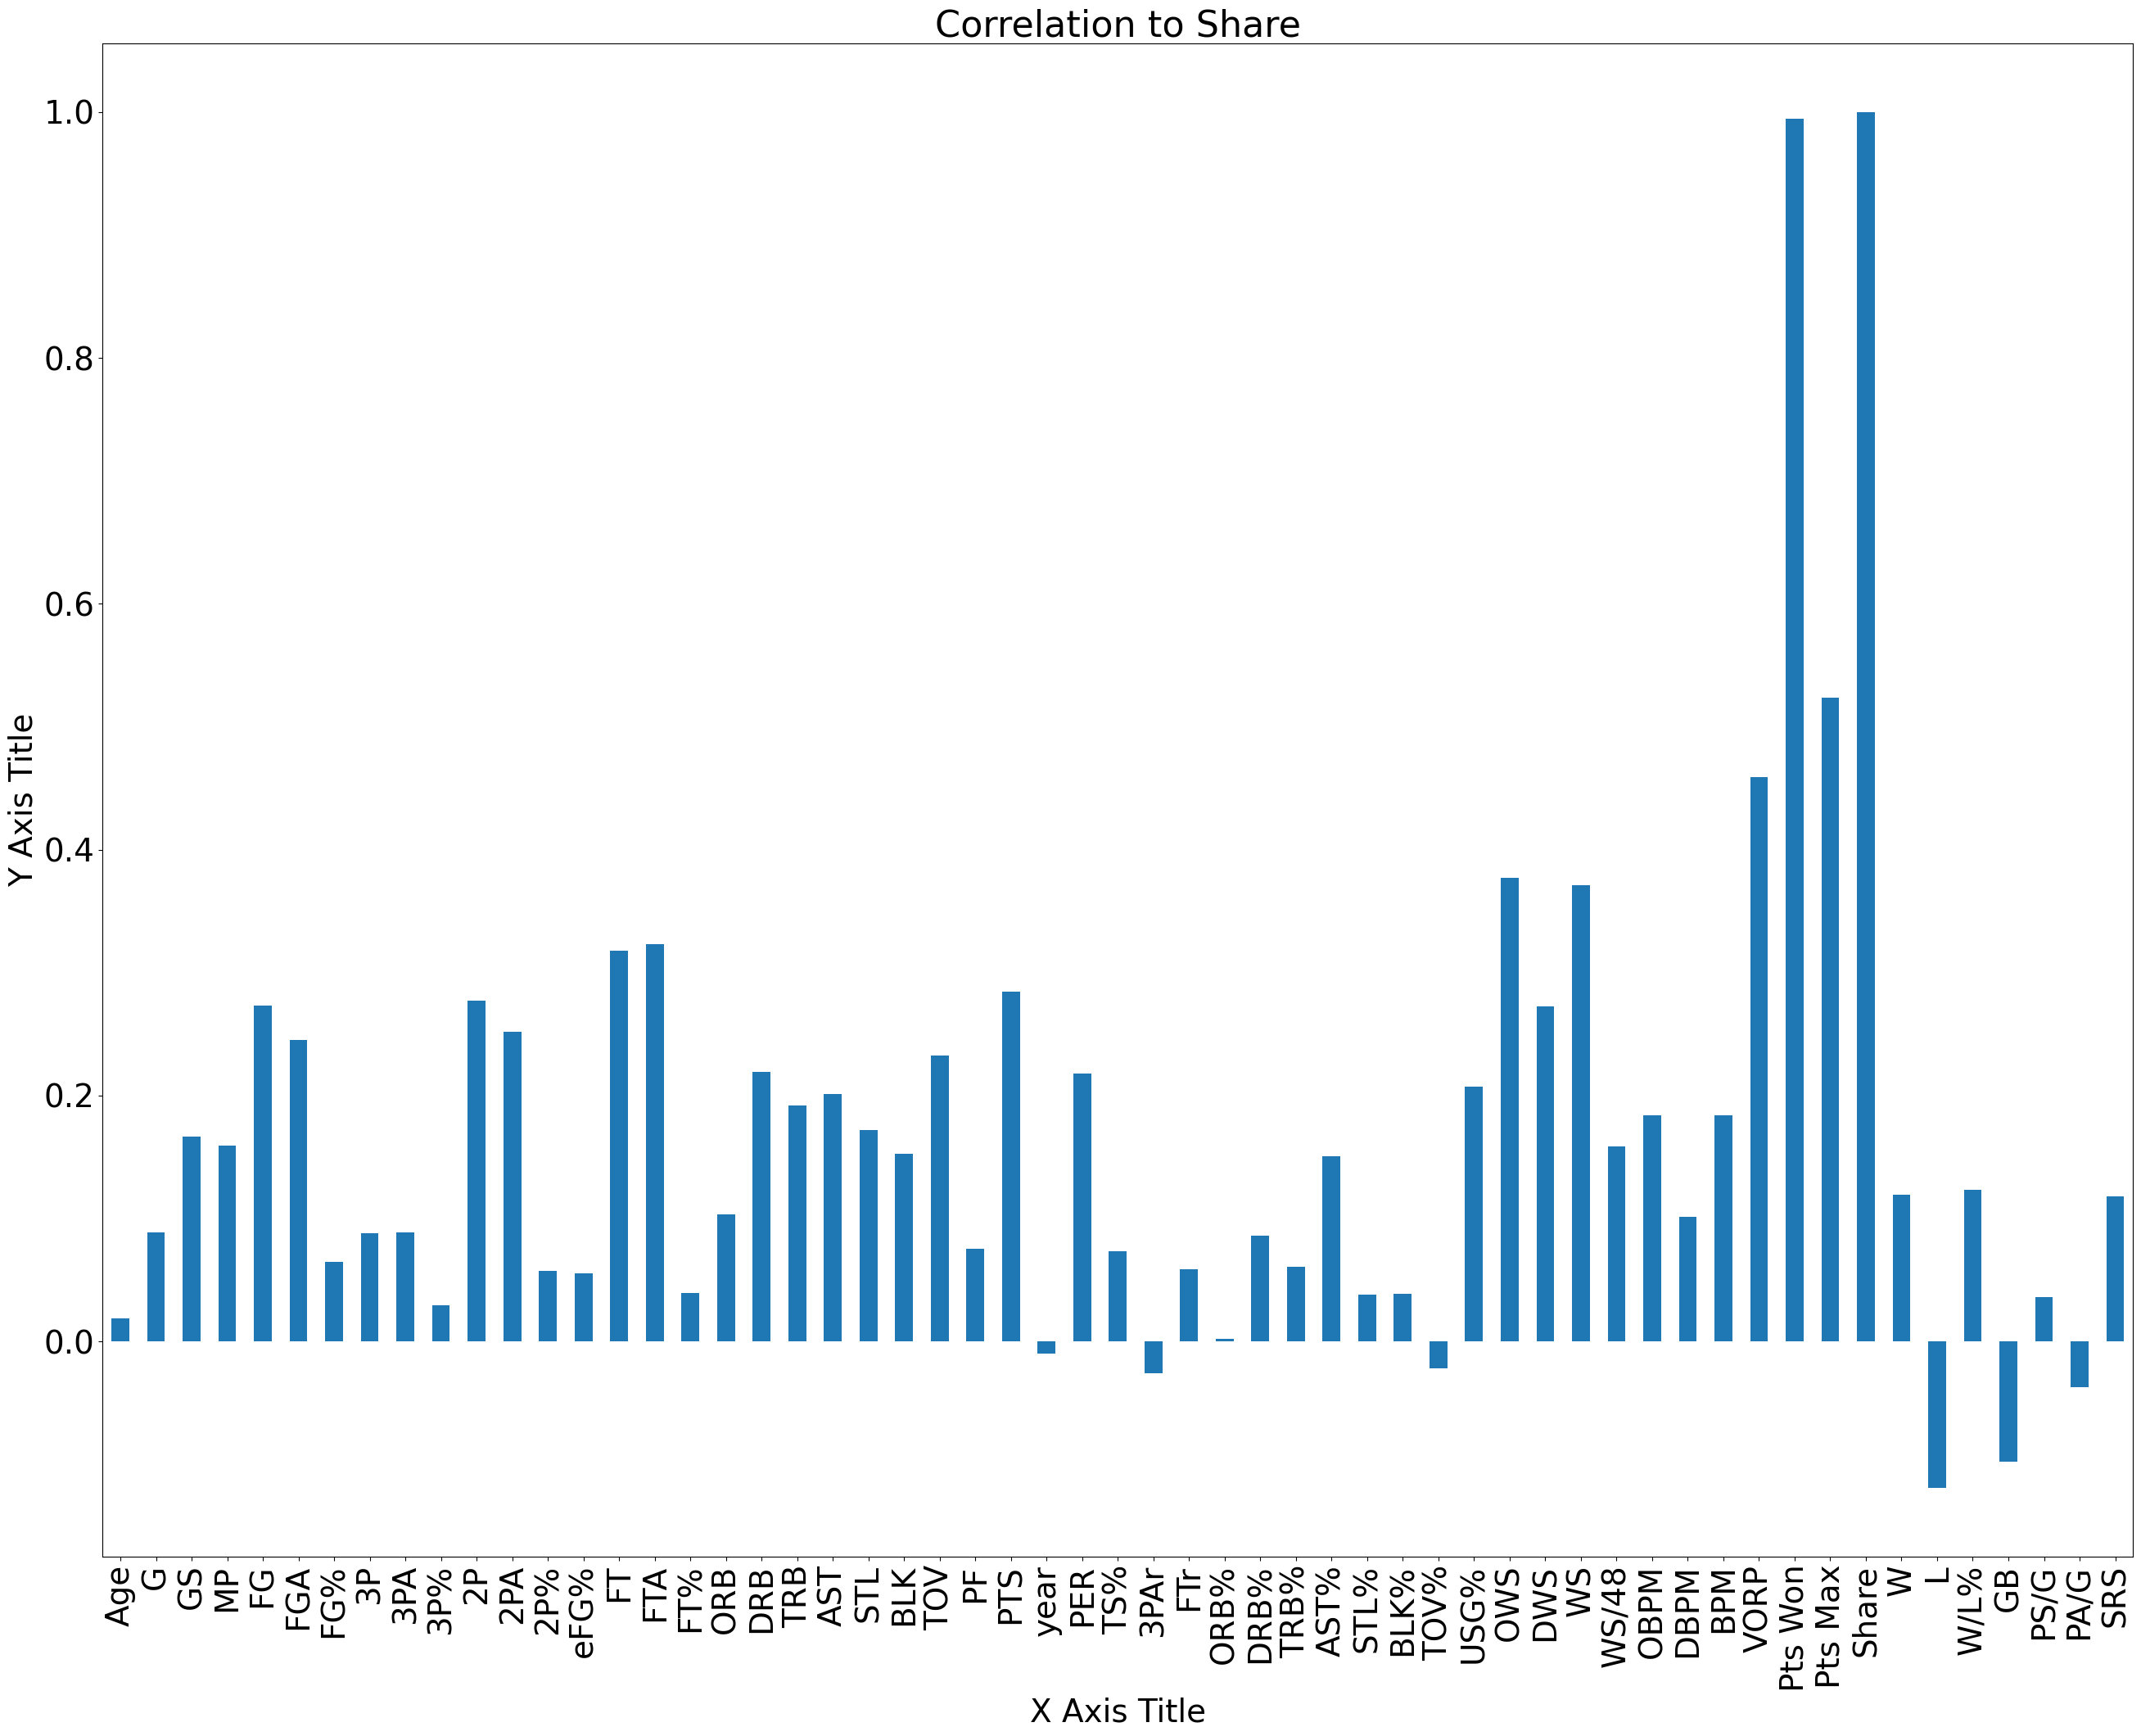

In [20]:
corr_num = numerical_df.corr()['Share']
plt.figure(figsize=(32,24))
corr_num.plot.bar()
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('X Axis Title', fontsize=28)
plt.ylabel('Y Axis Title', fontsize=28)
plt.title('Correlation to Share', fontsize=32)

In [21]:
numerical_df.corr()['Share'].sort_values(ascending=False)

Share      1.000000
Pts Won    0.994688
Pts Max    0.523973
VORP       0.459215
OWS        0.377287
WS         0.371118
FTA        0.323242
FT         0.317960
PTS        0.284548
2P         0.277279
FG         0.273348
DWS        0.272826
2PA        0.252143
FGA        0.244928
TOV        0.232659
DRB        0.219480
PER        0.217912
USG%       0.207016
AST        0.201248
TRB        0.192050
OBPM       0.183999
BPM        0.183995
STL        0.171757
GS         0.166344
MP         0.159174
WS/48      0.158789
BLK        0.152507
AST%       0.150955
W/L%       0.123259
W          0.119591
SRS        0.117731
ORB        0.103043
DBPM       0.101434
G          0.088749
3PA        0.088520
3P         0.088044
DRB%       0.085870
PF         0.075212
TS%        0.073203
FG%        0.064402
TRB%       0.060705
FTr        0.058426
2P%        0.057327
eFG%       0.055552
FT%        0.039420
BLK%       0.038584
STL%       0.038032
PS/G       0.035801
3P%        0.029407
Age        0.018716


concat the numerical data

In [22]:
year_share_mvp = data.groupby('year')['Share'].max().reset_index()

In [23]:
data_mvp_by_year = pd.merge(data, year_share_mvp, on=['year', 'Share'])

In [24]:
data_mvp_by_year.sort_values('year', ascending=True)

Player Pos  Age   Tm   G  GS    MP    FG   FGA    FG%  ...  \
0          Michael Jordan  SG   27  CHI  82  82  37.0  12.1  22.4  0.539  ...   
1          Michael Jordan  SG   28  CHI  80  80  38.8  11.8  22.7  0.519  ...   
26        Charles Barkley  PF   29  PHO  76  76  37.6   9.4  18.1  0.520  ...   
13        Hakeem Olajuwon   C   31  HOU  80  80  41.0  11.2  21.2  0.528  ...   
29         David Robinson   C   29  SAS  81  81  38.0   9.7  18.4  0.530  ...   
2          Michael Jordan  SG   32  CHI  82  82  37.7  11.2  22.6  0.495  ...   
32            Karl Malone  PF   33  UTA  82  82  36.6  10.5  19.2  0.550  ...   
3          Michael Jordan  SG   34  CHI  82  82  38.8  10.7  23.1  0.465  ...   
33            Karl Malone  PF   35  UTA  49  49  37.4   8.0  16.3  0.493  ...   
15       Shaquille O'Neal   C   27  LAL  79  79  40.0  12.1  21.1  0.574  ...   
24          Allen Iverson  SG   25  PHI  71  71  42.0  10.7  25.5  0.420  ...   
30             Tim Duncan  PF   25  SAS  82  82  40.6   9.3  18.3  0.508  ...   
31             Tim Duncan  PF   26  SAS  81  81  39.3   8.8  17.2  0.513  ...   
21          Kevin Garnett  PF   27  MIN  82  82  39.4   9.8  19.6  0.499  ...   
27             Steve Nash  PG   30  PHO  75  75  34.3   5.7  11.4  0.502  ...   
28             Steve Nash  PG   31  PHO  79  79  35.4   6.8  13.4  0.512  ...   
7           Dirk Nowitzki  PF   28  DAL  78  78  36.2   8.6  17.2  0.502  ...   
16            Kobe Bryant  SG   29  LAL  82  82  38.9   9.5  20.6  0.459  ...   
5            LeBron James  SF   24  CLE  81  81  37.7   9.7  19.9  0.489  ...   
6            LeBron James  SF   25  CLE  76  76  39.0  10.1  20.1  0.503  ...   
4            Derrick Rose  PG   22  CHI  81  81  37.4   8.8  19.7  0.445  ...   
17           LeBron James  SF   27  MIA  62  62  37.5  10.0  18.9  0.531  ...   
18           LeBron James  PF   28  MIA  76  76  37.9  10.1  17.8  0.565  ...   
22           Kevin Durant  SF   25  OKC  81  81  38.5  10.5  20.8  0.503  ...   
11          Stephen Curry  PG   26  GSW  80  80  32.7   8.2  16.8  0.487  ...   
12          Stephen Curry  PG   27  GSW  79  79  34.2  10.2  20.2  0.504  ...   
23      Russell Westbrook  PG   28  OKC  81  81  34.6  10.2  24.0  0.425  ...   
14           James Harden  SG   28  HOU  72  72  35.4   9.0  20.1  0.449  ...   
19  Giannis Antetokounmpo  PF   24  MIL  72  72  32.8  10.0  17.3  0.578  ...   
20  Giannis Antetokounmpo  PF   25  MIL  63  63  30.4  10.9  19.7  0.553  ...   
8            Nikola Jokić   C   25  DEN  72  72  34.6  10.2  18.0  0.566  ...   
9            Nikola Jokić   C   26  DEN  74  74  33.5  10.3  17.7  0.583  ...   
25            Joel Embiid   C   28  PHI  66  66  34.6  11.0  20.1  0.548  ...   
10           Nikola Jokić   C   28  DEN  79  79  34.6  10.4  17.9  0.583  ...   

    Pts Max  Share                    team   W   L   W/L%   GB   PS/G   PA/G  \
0     960.0  0.928           Chicago Bulls  61  21  0.744  0.0  110.0  101.0   
1     960.0  0.938           Chicago Bulls  67  15  0.817  0.0  109.9   99.5   
26    980.0  0.852            Phoenix Suns  62  20  0.756  0.0  113.4  106.7   
13   1010.0  0.880         Houston Rockets  58  24  0.707  0.0  101.1   96.8   
29   1050.0  0.858       San Antonio Spurs  62  20  0.756  0.0  106.6  100.6   
2    1130.0  0.986           Chicago Bulls  72  10  0.878  0.0  105.2   92.9   
32   1150.0  0.857               Utah Jazz  64  18  0.780  0.0  103.1   94.3   
3    1160.0  0.934           Chicago Bulls  62  20  0.756  0.0   96.7   89.6   
33   1180.0  0.701               Utah Jazz  37  13  0.740  0.0   93.3   86.8   
15   1210.0  0.998      Los Angeles Lakers  67  15  0.817  0.0  100.8   92.3   
24   1240.0  0.904      Philadelphia 76ers  56  26  0.683  0.0   94.7   90.4   
30   1260.0  0.757       San Antonio Spurs  58  24  0.707  0.0   96.7   90.5   
31   1190.0  0.808       San Antonio Spurs  60  22  0.732  0.0   95.8   90.4   
21   1230.0  0.991  Minnesota Timberwolves  58  24  0.707  0.0 

In [25]:
len(data.columns)

61

In [26]:
for_plot = data_mvp_by_year[['G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'Pts Won', 'Pts Max', 'Share','W', 'L', 'W/L%', 'GB',
       'PS/G', 'PA/G', 'SRS']]

Plot the statistic of MVP winner from 1991 - 2024

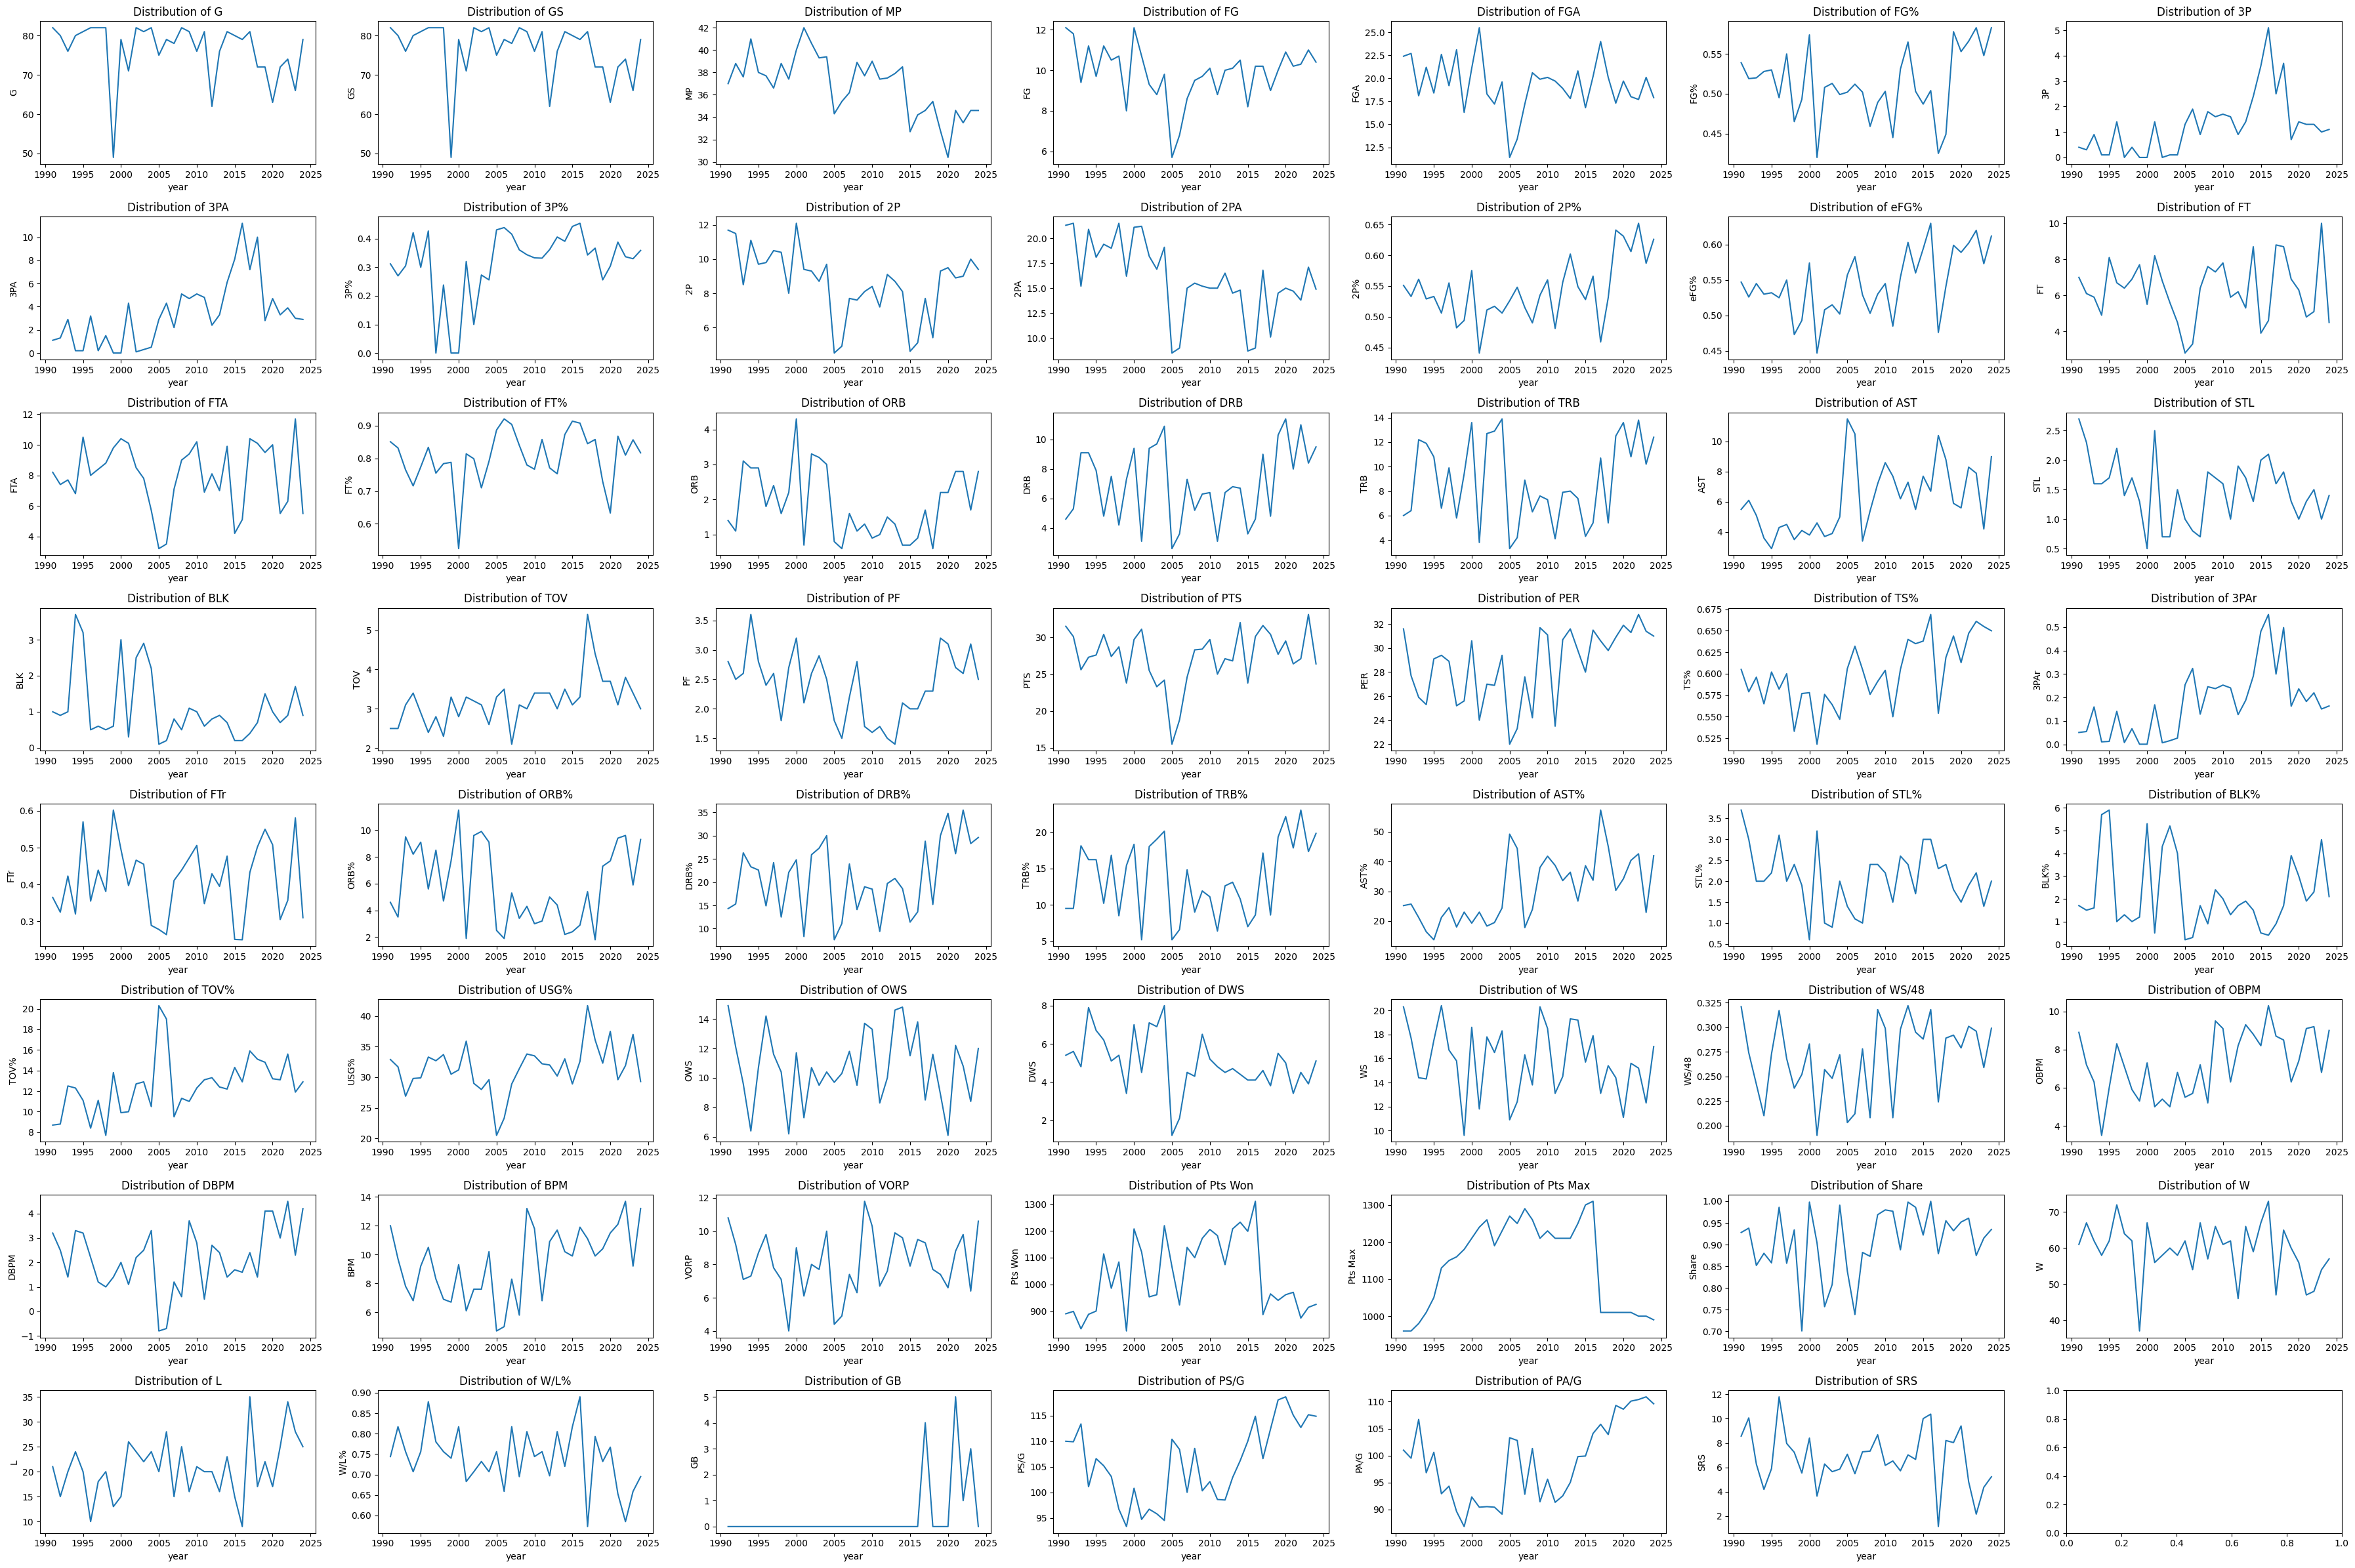

In [27]:
fig, ax = plt.subplots(nrows=8, ncols=7, figsize=(36, 24))
axes = ax.flatten()

for i, col in enumerate(for_plot.columns):
    sns.lineplot(x=data_mvp_by_year['year'],y=for_plot[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [28]:
for_plot.min()

G           49.000
GS          49.000
MP          30.400
FG           5.700
FGA         11.400
FG%          0.420
3P           0.000
3PA          0.000
3P%          0.000
2P           4.500
2PA          8.500
2P%          0.441
eFG%         0.447
FT           2.800
FTA          3.200
FT%          0.524
ORB          0.600
DRB          2.600
TRB          3.300
AST          2.900
STL          0.500
BLK          0.100
TOV          2.100
PF           1.400
PTS         15.500
PER         22.000
TS%          0.518
3PAr         0.001
FTr          0.250
ORB%         1.800
DRB%         7.600
TRB%         5.200
AST%        13.700
STL%         0.600
BLK%         0.200
TOV%         7.700
USG%        20.500
OWS          6.100
DWS          1.200
WS           9.600
WS/48        0.190
OBPM         3.500
DBPM        -0.800
BPM          4.700
VORP         4.000
Pts Won    827.000
Pts Max    960.000
Share        0.701
W           37.000
L            9.000
W/L%         0.573
GB           0.000
PS/G        

checking coreelation value to target col

In [29]:
numerical_df.corr()['Share'].sort_values(ascending=False)

Share      1.000000
Pts Won    0.994688
Pts Max    0.523973
VORP       0.459215
OWS        0.377287
WS         0.371118
FTA        0.323242
FT         0.317960
PTS        0.284548
2P         0.277279
FG         0.273348
DWS        0.272826
2PA        0.252143
FGA        0.244928
TOV        0.232659
DRB        0.219480
PER        0.217912
USG%       0.207016
AST        0.201248
TRB        0.192050
OBPM       0.183999
BPM        0.183995
STL        0.171757
GS         0.166344
MP         0.159174
WS/48      0.158789
BLK        0.152507
AST%       0.150955
W/L%       0.123259
W          0.119591
SRS        0.117731
ORB        0.103043
DBPM       0.101434
G          0.088749
3PA        0.088520
3P         0.088044
DRB%       0.085870
PF         0.075212
TS%        0.073203
FG%        0.064402
TRB%       0.060705
FTr        0.058426
2P%        0.057327
eFG%       0.055552
FT%        0.039420
BLK%       0.038584
STL%       0.038032
PS/G       0.035801
3P%        0.029407
Age        0.018716


In [30]:
data_mvp_by_year.min()

Player    Allen Iverson
Pos                   C
Age                  22
Tm                  CHI
G                    49
              ...      
W/L%              0.573
GB                  0.0
PS/G               93.3
PA/G               86.8
SRS                1.14
Length: 61, dtype: object

Checking the outliers of the data

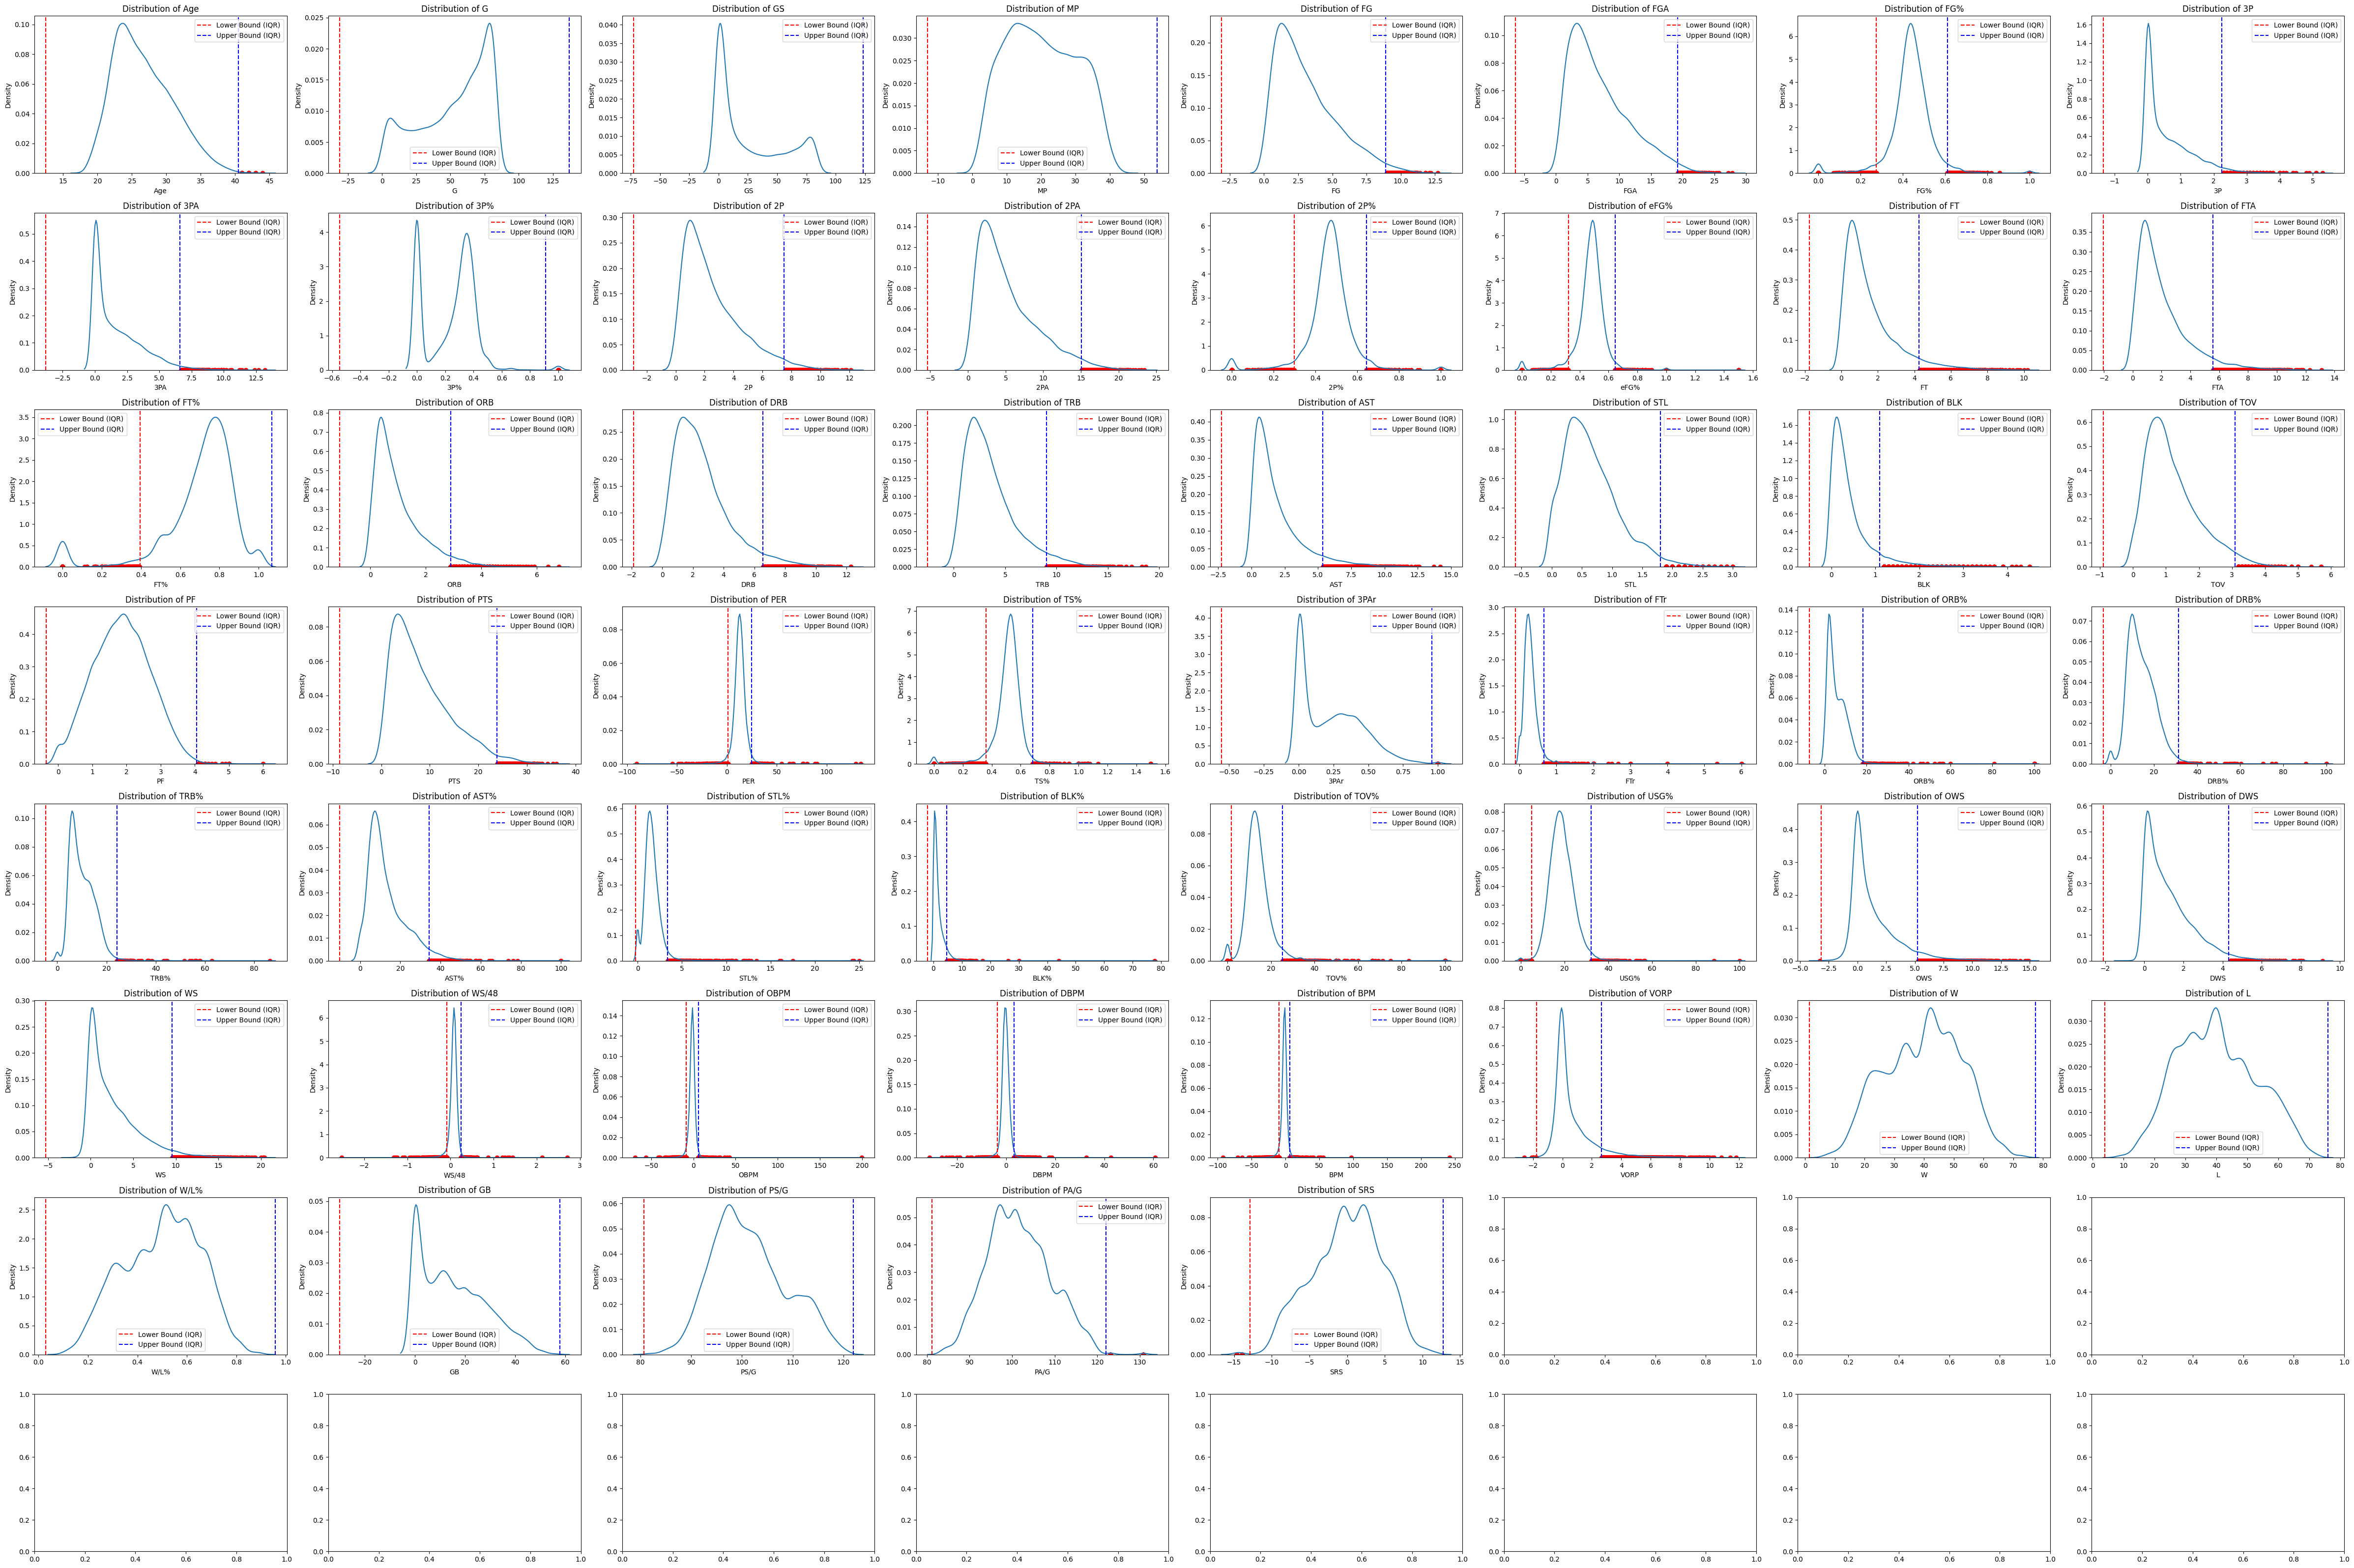

In [31]:
fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(48, 32))
axes = ax.flatten()

for i, col in enumerate(X_train_num.columns):
    sns.kdeplot(X_train_num[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    

    q1 = np.percentile(X_train_num[col], 25)
    q3 = np.percentile(X_train_num[col], 75)
    iqr = q3 - q1
    

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr


    axes[i].axvline(lower_bound, color='red', linestyle='--', label='Lower Bound (IQR)')
    axes[i].axvline(upper_bound, color='blue', linestyle='--', label='Upper Bound (IQR)')
    
 
    outliers = X_train_num[(X_train_num[col] < lower_bound) | (X_train_num[col] > upper_bound)]
    axes[i].scatter(outliers[col], np.zeros_like(outliers[col]), color='red')

    axes[i].legend()

plt.tight_layout()
plt.show()

we can see that there are no player that have 3 point attempt and have played in a season less than 20 games (logically correct)

In [32]:
train[(train['3PA'] > 10.0)&(train['G']< 20)]

Empty DataFrame
Columns: [Player, Pos, Age, Tm, G, GS, MP, FG, FGA, FG%, 3P, 3PA, 3P%, 2P, 2PA, 2P%, eFG%, FT, FTA, FT%, ORB, DRB, TRB, AST, STL, BLK, TOV, PF, PTS, year, PER, TS%, 3PAr, FTr, ORB%, DRB%, TRB%, AST%, STL%, BLK%, TOV%, USG%, OWS, DWS, WS, WS/48, OBPM, DBPM, BPM, VORP, Pts Won, Pts Max, Share, team, W, L, W/L%, GB, PS/G, PA/G, SRS]
Index: []

[0 rows x 61 columns]

In [33]:
train[(train['eFG%']>1.0)]

Player Pos  Age   Tm  G  GS   MP   FG  FGA  FG%  ...  Pts Max  \
442      Jordan Sibert  SG   26  ATL  1   0  4.0  1.0  1.0  1.0  ...      0.0   
3580     Tyson Wheeler  PG   23  DEN  1   0  3.0  1.0  1.0  1.0  ...      0.0   
4764     Dajuan Wagner  SG   23  GSW  1   0  7.0  1.0  1.0  1.0  ...      0.0   
9072     Anthony Brown  SF   25  MIN  1   0  4.0  1.0  1.0  1.0  ...      0.0   
15039  Naz Mitrou-Long  SG   24  UTA  1   0  1.0  1.0  1.0  1.0  ...      0.0   

       Share                    team   W   L   W/L%    GB   PS/G   PA/G   SRS  
442      0.0           Atlanta Hawks  29  53  0.354  13.0  113.3  119.4 -6.06  
3580     0.0          Denver Nuggets  14  36  0.280  23.0   93.5  100.1 -6.67  
4764     0.0   Golden State Warriors  42  40  0.512  19.0  106.5  106.9  0.00  
9072     0.0  Minnesota Timberwolves  47  35  0.573   2.0  109.5  107.3  2.35  
15039    0.0               Utah Jazz  48  34  0.585   1.0  104.1   99.8  4.47  

[5 rows x 61 columns]

In [34]:
train[(train['USG%'] > 45) & (train['G'] < 20)]

Player Pos  Age   Tm  G  GS   MP   FG  FGA    FG%  ...  \
79         Howard Nathan  PG   24  ATL  5   0  3.0  1.0  1.8  0.556  ...   
513     Donovan Williams  SG   21  ATL  2   0  2.0  1.0  2.5  0.400  ...   
1875          Jack Haley   C   32  CHI  1   0  7.0  2.0  6.0  0.333  ...   
3574       Kelly McCarty  SG   23  DEN  2   0  2.0  1.0  1.5  0.667  ...   
5491      Terrence Jones  PF   27  HOU  2   0  2.5  0.5  2.0  0.250  ...   
6371           Von Wafer  SF   21  LAC  1   0  1.0  0.0  1.0  0.000  ...   
6770          Shea Seals  SG   22  LAL  4   0  2.3  0.3  2.0  0.125  ...   
7945     DeAndre Liggins  SG   25  MIA  1   0  1.0  1.0  1.0  1.000  ...   
9309    Gheorghe Mureșan   C   27  NJN  1   0  1.0  0.0  1.0  0.000  ...   
9444           Mile Ilić   C   22  NJN  5   0  1.2  0.0  0.6  0.000  ...   
10013          Ben Davis  PF   26  NYK  8   0  2.6  0.9  2.1  0.412  ...   
10099      Jackie Butler   C   19  NYK  3   0  1.7  1.3  1.3  1.000  ...   
10759  Darrell Armstrong  PG   26  ORL  3   0  2.7  1.0  2.7  0.375  ...   
12264         Paris Bass  SF   26  PHO  2   0  3.5  1.0  3.0  0.333  ...   
13398       Chuck Nevitt   C   34  SAS  1   0  1.0  0.0  0.0  0.000  ...   
14211         Mark Baker  PG   29  TOR  1   0  2.0  0.0  1.0  0.000  ...   
14650       Bob Thornton  PF   29  UTA  2   0  3.0  0.5  3.5  0.143  ...   

       Pts Max  Share                  team   W   L   W/L%    GB   PS/G  \
79         0.0    0.0         Atlanta Hawks  46  36  0.561  26.0   98.3   
513        0.0    0.0         Atlanta Hawks  41  41  0.500   3.0  118.4   
1875       0.0    0.0         Chicago Bulls  72  10  0.878   0.0  105.2   
3574       0.0    0.0        Denver Nuggets  14  36  0.280  23.0   93.5   
5491       0.0    0.0       Houston Rockets  53  29  0.646   0.0  113.9   
6371       0.0    0.0  Los Angeles Clippers  40  42  0.488  21.0   95.6   
6770       0.0    0.0    Los Angeles Lakers  61  21  0.744   0.0  105.5   
7945       0.0    0.0            Miami Heat  54  28  0.659   0.0  102.2   
9309       0.0    0.0       New Jersey Nets  16  34  0.320  17.0   91.4   
9444       0.0    0.0       New Jersey Nets  41  41  0.500   6.0   97.6   
10013      0.0    0.0       New York Knicks  27  23  0.540   6.0   86.4   
10099      0.0    0.0       New York Knicks  33  49  0.402  12.0   97.3   
10759      0.0    0.0         Orlando Magic  57  25  0.695   0.0  110.9   
12264      0.0    0.0          Phoenix Suns  64  18  0.780   0.0  114.8   
13398      0.0    0.0     San Antonio Spurs  55  27  0.671   3.0  100.0   
14211      0.0    0.0       Toronto Raptors  23  27  0.460  10.0   91.1   
14650      0.0    0.0             Utah Jazz  55  27  0.671   0.0  108.3   

        PA/G    SRS  
79      97.1   1.29  
513    118.1   0.32  
1875    92.9  11.80  
3574   100.1  -6.67  
5491   109.1   4.96  
6371    96.1  -0.07  
6770    97.8   6.88  
7945    97.4   4.15  
9309    95.2  -3.20  
9444    98.3  -1.00  
10013   85.4   1.45  
10099   99.7  -2.72  
10759  103.8   6.44  
12264  107.3   6.94  
13398   94.8   5.05  
14211   92.8  -1.32  
14650  101.9   5.70  

[17 rows x 61 columns]

In [35]:
idx_to_drop = train[
    (train['3P%'] > 0.8) & (train['G']<20)|
    (train['STL%'] > 7.5) & (train['G'] < 20)|
    (train['BPM'] > 50) & (train['G'] < 20)|
    (train['DBPM'] > 8) & (train['G'] < 20)|
    (train['OBPM'] > 30) & (train['G'] < 20)|
    (train['DBPM'] < -20) & (train['G'] < 20)|
    (train['OBPM'] < -30) & (train['G'] < 20)|
    (train['WS/48']>0.3) & (train['G'] < 20)|
    (train['WS/48'] < -0.4) & (train['G'] < 20)|
    (train['DRB%'] > 40) & (train['G'] < 20)|
    (train['ORB%'] > 30) & (train['G'] < 20)|
    (train['USG%'] > 45) & (train['G'] < 20)|
    (train['TOV%']>60)|
    (train['BLK%']>40)|
    (train['AST%']>60)|
    (train['TRB%']>45)|
    (train['TS%']>1)|
    (train['PER']>45)|
    (train['PER']<-40)|
    (train['eFG%']>1.0)
    
].index.tolist()

In [36]:
len(idx_to_drop)

249

In [37]:
X_train_dropped = X_train.drop(index=idx_to_drop)
y_train_dropped = y_train.drop(index=idx_to_drop)

In [38]:
X_train_dropped.shape

(14987, 58)

In [39]:
print('Shape of X train after dropped:', X_train_dropped.shape)
X_train_dropped.shape

Shape of X train after dropped: (14987, 58)


(14987, 58)

In [40]:
train.shape

(15236, 61)

In [41]:
X_train_num, X_train_cat = split_numerical_categorical(data=X_train_dropped,num_cols=num_column,cat_cols=cat_column)

Data num shape: (14987, 53)
Data cat shape: (14987, 1)


In [42]:
X_train_cat.isna().sum()

Pos    0
dtype: int64

In [43]:

def cat_OHE_encoder_fit(data):
    ''' 
    Fit a OneHotEncoder to the categorical data.

    Parameters

    data : pandas.DataFrame
    DataFrame containing categorical data to be encoded.

    Returns

    OneHotEncoder
    A fitted OneHotEncoder object, which can be used to transform the data
    '''
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(data)
    return encoder

def cat_OHE_encoder_transform(data, encoder):
    ''' 
    Parameters

    data : pandas.DataFrame
    DataFrame containing categorical data to be encoded.

    encoder : OneHotEncoder
    A fitted OneHotEncoder object used to encode the data.

    Returns

    pandas.DataFrame
    '''
    encoded_array = encoder.transform(data)
    feature_names = encoder.get_feature_names_out()
    cleaned_columns = [col.split('_')[-1] for col in feature_names]
    encoded_data = pd.DataFrame(encoded_array, columns=cleaned_columns, index=data.index)
    return encoded_data

In [44]:
ohe_data = X_train_cat
cat_ohe_encoder = cat_OHE_encoder_fit(ohe_data)
X_train_cat_ohe_encoded = cat_OHE_encoder_transform(ohe_data,cat_ohe_encoder)

In [45]:
def concat_data(num_data, cat_data):
    '''  
    Concatenates numerical and categorical data into a single DataFrame.

    This function ensures that the indices of the numerical and categorical data match before concatenation. If the indices do not match, the categorical data is reindexed to match the numerical data.

    Parameters:
    - num_data (pd.DataFrame): DataFrame containing numerical data.
    - cat_data (pd.DataFrame): DataFrame containing categorical data.

    Returns:
    - concatenated_data (pd.DataFrame): DataFrame with both numerical and categorical data concatenated along columns.
    '''
    if not num_data.index.equals(cat_data.index):
        cat_data = cat_data.reindex(num_data.index)
    concatenated_data = pd.concat([num_data, cat_data], axis=1)
    print(f'Numerical data shape  : {num_data.shape}')
    print(f'Categorical data shape: {cat_data.shape}')
    print(f'Concat data shape     : {concatenated_data.shape}')
    return concatenated_data

In [46]:
X_train_concat = concat_data(X_train_num,X_train_cat_ohe_encoded)

Numerical data shape  : (14987, 53)
Categorical data shape: (14987, 5)
Concat data shape     : (14987, 58)


In [47]:
X_train_concat.head()

Age   G  GS    MP   FG   FGA    FG%   3P  3PA    3P%  ...   W/L%    GB  \
0   29  79  79  32.7  5.6  12.9  0.435  1.1  3.3  0.336  ...  0.524  18.0   
1   31  81  81  38.0  9.5  20.2  0.470  1.0  3.1  0.341  ...  0.524  18.0   
2   25  78   2  14.9  2.2   4.6  0.489  0.0  0.0  0.667  ...  0.524  18.0   
3   23   4   0   2.3  0.0   0.0  0.000  0.0  0.0  0.000  ...  0.524  18.0   
4   28  79   2  23.6  5.0  10.9  0.461  0.2  0.6  0.286  ...  0.524  18.0   

    PS/G   PA/G   SRS    C   PF   PG   SF   SG  
0  109.8  109.0  0.72  0.0  0.0  1.0  0.0  0.0  
1  109.8  109.0  0.72  0.0  0.0  0.0  1.0  0.0  
2  109.8  109.0  0.72  0.0  0.0  0.0  1.0  0.0  
3  109.8  109.0  0.72  1.0  0.0  0.0  0.0  0.0  
4  109.8  109.0  0.72  0.0  0.0  0.0  0.0  1.0  

[5 rows x 58 columns]

In [48]:
def fit_scaler(data):
    '''  
    Fits a StandardScaler to the numerical data.

    This function computes the mean and standard deviation for each feature in the data to standardize them.

    Parameters:
    data (pd.DataFrame): DataFrame containing numerical data to be scaled.

    Returns:
    scaler (StandardScaler): A fitted StandardScaler object that can be used to transform the data.
    '''
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler
def transform_scaler(data, scaler):
    '''  
    Transforms the numerical data using a fitted StandardScaler.

    This function scales the data based on the mean and standard deviation computed by the fitted StandardScaler.

    Parameters:
    data (pd.DataFrame): DataFrame containing numerical data to be scaled.
    scaler (StandardScaler): A fitted StandardScaler object used for scaling the data.

    Returns:
    scaled_data (pd.DataFrame): DataFrame containing the scaled numerical data.
    '''
    scaled_array = scaler.transform(data)
    scaled_data = pd.DataFrame(scaled_array, index=data.index, columns=data.columns)
    return scaled_data

In [49]:
scaler = fit_scaler(X_train_concat)
X_train_clean = transform_scaler(X_train_concat, scaler)

In [50]:
X_train_clean.shape

(14987, 58)

In [51]:
X_train_num.columns

Index(['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'W', 'L', 'W/L%', 'GB',
       'PS/G', 'PA/G', 'SRS'],
      dtype='object')

In [52]:
def preprocess_data(data, num_cols,cat_cols,cat_ohe_encoder,scaler):
    num_data = data[num_cols]
    cat_data = data[cat_cols]
    cat_ohe_data_encoded = cat_OHE_encoder_transform(cat_data,cat_ohe_encoder)
    processed_data = concat_data(num_data, cat_ohe_data_encoded)
    print(f"Original data shape:{processed_data.shape}")
    clean_data = transform_scaler(processed_data, scaler)
    print(f'Mapped data shape  : {clean_data.shape}')
    return clean_data

In [53]:
X_train_clean = preprocess_data(
    data=X_train_dropped, 
    num_cols=num_column, 
    cat_cols=cat_column, 
    cat_ohe_encoder = cat_ohe_encoder,
    scaler=scaler
)

Numerical data shape  : (14987, 53)
Categorical data shape: (14987, 5)
Concat data shape     : (14987, 58)
Original data shape:(14987, 58)
Mapped data shape  : (14987, 58)


In [54]:
y_train_dropped.shape

(14987,)

In [55]:
X_test_clean = preprocess_data(
    data=X_test, 
    num_cols=num_column, 
    cat_cols=cat_column, 
    cat_ohe_encoder = cat_ohe_encoder,
    scaler=scaler
)

Numerical data shape  : (572, 53)
Categorical data shape: (572, 5)
Concat data shape     : (572, 58)
Original data shape:(572, 58)
Mapped data shape  : (572, 58)


In [56]:

def extract_cv_results(cv_obj):

    best_train_score = -cv_obj.cv_results_['mean_train_score'][cv_obj.best_index_]

    best_valid_score = -cv_obj.best_score_  
    
    best_params = cv_obj.best_params_
    
    return best_train_score, best_valid_score, best_params


im using time series cv since my data was temporal

In [57]:
tscv = TimeSeriesSplit(n_splits=5)

Experimenting PCA, since my data was high dimentionality

In [58]:
pcas = PCA(n_components=0.95)
X_train_pca = pcas.fit_transform(X_train_clean)
X_test_pca = pcas.transform(X_test_clean)

-------------

# Modeling the data

### Baseline

In [59]:
param_grid_base = {'strategy': ['mean']}
baseline_model = DummyRegressor()
reg_base = GridSearchCV(baseline_model, param_grid_base, scoring='neg_root_mean_squared_error', cv=tscv,return_train_score=True)
reg_base.fit(X_train_clean, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DummyRegressor(), param_grid={'strategy': ['mean']},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [60]:
train_base, valid_base, best_param_base = extract_cv_results(reg_base)

print(f'Train score - Baseline model: {train_base}')
print(f'Valid score - Baseline model: {valid_base}')
print(f'Best Params - Baseline model: {best_param_base}')

Train score - Baseline model: 0.05886765934679716
Valid score - Baseline model: 0.05867117786066176
Best Params - Baseline model: {'strategy': 'mean'}


----------------------------
### Baseline with PCA

In [61]:
param_grid_base_pca = {'strategy': ['mean']}
baseline_model_pca = DummyRegressor()
reg_base_pca = GridSearchCV(baseline_model_pca, param_grid_base_pca, scoring='neg_root_mean_squared_error', cv=tscv,return_train_score=True)
reg_base_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DummyRegressor(), param_grid={'strategy': ['mean']},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [62]:
train_base_pca, valid_base_pca, best_param_base_pca = extract_cv_results(reg_base_pca)

print(f'Train score - Baseline model: {train_base_pca}')
print(f'Valid score - Baseline model: {valid_base_pca}')
print(f'Best Params - Baseline model: {best_param_base_pca}')

Train score - Baseline model: 0.05886765934679716
Valid score - Baseline model: 0.05867117786066176
Best Params - Baseline model: {'strategy': 'mean'}


-------------------
### Ridge

In [63]:
param_grid_ridge = {
    'alpha': np.logspace(-6, 10, 100)  # Regularization strength from 10^-6 to 10^10
}
ridge = Ridge()
reg_ridge = GridSearchCV(ridge, param_grid_ridge, scoring='neg_root_mean_squared_error', cv=tscv,return_train_score=True)
reg_ridge.fit(X_train_clean, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-06, 1.45082878e-06, 2.10490414e-06, 3.05385551e-06,
       4.43062146e-06, 6.42807312e-06, 9.32603347e-06, 1.35304777e-05,
       1.96304065e-05, 2.84803587e-05, 4.13201240e-05, 5.99484250e-05,
       8.69749003e-05, 1.26185688e-04, 1.83073828...
       8.49753436e+06, 1.23284674e+07, 1.78864953e+07, 2.59502421e+07,
       3.76493581e+07, 5.46227722e+07, 7.92482898e+07, 1.14975700e+08,
       1.66810054e+08, 2.42012826e+08, 3.51119173e+08, 5.09413801e+08,
       7.39072203e+08, 1.07226722e+09, 1.55567614e+09, 2.25701972e+09,
       3.27454916e+09, 4.75081016e+09, 6.89261210e+09, 1.00000000e+10])},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [64]:
train_ridge, valid_ridge, best_param_ridge = extract_cv_results(reg_ridge)

print(f'Train score - Ridge model: {train_ridge}')
print(f'Valid score - Ridge model: {valid_ridge} ')
print(f'Best Params - Ridge model: {best_param_ridge}')

Train score - Ridge model: 0.04888890242593229
Valid score - Ridge model: 0.05054427083254134 
Best Params - Ridge model: {'alpha': np.float64(39.44206059437664)}


-----------------------------------
### Ridge with PCA

In [65]:
param_grid_ridge_pca = {
    'alpha': np.logspace(-6, 10, 100)  # Regularization strength from 10^-6 to 10^10
}
ridge = Ridge()
reg_ridge_pca = GridSearchCV(ridge, param_grid_ridge, scoring='neg_root_mean_squared_error', cv=tscv,return_train_score=True)
reg_ridge_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-06, 1.45082878e-06, 2.10490414e-06, 3.05385551e-06,
       4.43062146e-06, 6.42807312e-06, 9.32603347e-06, 1.35304777e-05,
       1.96304065e-05, 2.84803587e-05, 4.13201240e-05, 5.99484250e-05,
       8.69749003e-05, 1.26185688e-04, 1.83073828...
       8.49753436e+06, 1.23284674e+07, 1.78864953e+07, 2.59502421e+07,
       3.76493581e+07, 5.46227722e+07, 7.92482898e+07, 1.14975700e+08,
       1.66810054e+08, 2.42012826e+08, 3.51119173e+08, 5.09413801e+08,
       7.39072203e+08, 1.07226722e+09, 1.55567614e+09, 2.25701972e+09,
       3.27454916e+09, 4.75081016e+09, 6.89261210e+09, 1.00000000e+10])},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [66]:
train_ridge_pca, valid_ridge_pca, best_param_ridge_pca = extract_cv_results(reg_ridge_pca)

print(f'Train score - Ridge model: {train_ridge_pca}')
print(f'Valid score - Ridge model: {valid_ridge_pca} ')
print(f'Best Params - Ridge model: {best_param_ridge_pca}')

Train score - Ridge model: 0.051363597202673125
Valid score - Ridge model: 0.0519064981859809 
Best Params - Ridge model: {'alpha': np.float64(367.8379771828634)}


--------
### Lasso

In [67]:
param_grid_lasso = {
    'alpha':np.logspace(-6, 10, 100)
}


lasso = Lasso()

reg_lasso = GridSearchCV(lasso, param_grid_lasso, cv=tscv,scoring='neg_root_mean_squared_error', return_train_score=True)
reg_lasso.fit(X_train_clean, y_train_dropped)


d:\software\New folder\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.547e+00, tolerance: 8.518e-04
  model = cd_fast.enet_coordinate_descent(
d:\software\New folder\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.949e+00, tolerance: 1.645e-03
  model = cd_fast.enet_coordinate_descent(
d:\software\New folder\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.997e+00, tolerance: 2.5

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-06, 1.45082878e-06, 2.10490414e-06, 3.05385551e-06,
       4.43062146e-06, 6.42807312e-06, 9.32603347e-06, 1.35304777e-05,
       1.96304065e-05, 2.84803587e-05, 4.13201240e-05, 5.99484250e-05,
       8.69749003e-05, 1.26185688e-04, 1.83073828...
       8.49753436e+06, 1.23284674e+07, 1.78864953e+07, 2.59502421e+07,
       3.76493581e+07, 5.46227722e+07, 7.92482898e+07, 1.14975700e+08,
       1.66810054e+08, 2.42012826e+08, 3.51119173e+08, 5.09413801e+08,
       7.39072203e+08, 1.07226722e+09, 1.55567614e+09, 2.25701972e+09,
       3.27454916e+09, 4.75081016e+09, 6.89261210e+09, 1.00000000e+10])},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [68]:
train_lasso, valid_lasso, best_param_lasso = extract_cv_results(reg_lasso)

print(f'Train score - Lasso model: {train_lasso}')
print(f'Valid score - Lasso model: {valid_lasso}')
print(f'Best Params - Lasso model: {best_param_lasso}')

Train score - Lasso model: 0.04883227508549625
Valid score - Lasso model: 0.05067157306005893
Best Params - Lasso model: {'alpha': np.float64(5.994842503189409e-05)}


-------
### Lasso with PCA

In [69]:
param_grid_lasso_pca = {
    'alpha':np.logspace(-6, 10, 100)
}


lasso = Lasso()

reg_lasso_pca = GridSearchCV(lasso, param_grid_lasso, cv=tscv,scoring='neg_root_mean_squared_error', return_train_score=True)
reg_lasso_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-06, 1.45082878e-06, 2.10490414e-06, 3.05385551e-06,
       4.43062146e-06, 6.42807312e-06, 9.32603347e-06, 1.35304777e-05,
       1.96304065e-05, 2.84803587e-05, 4.13201240e-05, 5.99484250e-05,
       8.69749003e-05, 1.26185688e-04, 1.83073828...
       8.49753436e+06, 1.23284674e+07, 1.78864953e+07, 2.59502421e+07,
       3.76493581e+07, 5.46227722e+07, 7.92482898e+07, 1.14975700e+08,
       1.66810054e+08, 2.42012826e+08, 3.51119173e+08, 5.09413801e+08,
       7.39072203e+08, 1.07226722e+09, 1.55567614e+09, 2.25701972e+09,
       3.27454916e+09, 4.75081016e+09, 6.89261210e+09, 1.00000000e+10])},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [70]:
train_lasso_pca, valid_lasso_pca, best_param_lasso_pca = extract_cv_results(reg_lasso_pca)

print(f'Train score - Lasso model: {train_lasso_pca}')
print(f'Valid score - Lasso model: {valid_lasso_pca}')
print(f'Best Params - Lasso model: {best_param_lasso_pca}')

Train score - Lasso model: 0.051352448121149495
Valid score - Lasso model: 0.05191633216832155
Best Params - Lasso model: {'alpha': np.float64(0.00038535285937105315)}


----------
### ElasticNet

In [71]:
param_grid = {'alpha':np.logspace(-6, 10, 100),
            'l1_ratio':[0.01,0.1,1]}
elastic_net_model = ElasticNet()
reg_elastic = GridSearchCV(elastic_net_model, param_grid,cv=tscv,scoring='neg_root_mean_squared_error',return_train_score=True)
reg_elastic.fit(X_train_clean, y_train_dropped)

d:\software\New folder\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.782e+00, tolerance: 8.518e-04
  model = cd_fast.enet_coordinate_descent(
d:\software\New folder\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.666e+00, tolerance: 1.645e-03
  model = cd_fast.enet_coordinate_descent(
d:\software\New folder\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.917e+00, tolerance: 2.5

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-06, 1.45082878e-06, 2.10490414e-06, 3.05385551e-06,
       4.43062146e-06, 6.42807312e-06, 9.32603347e-06, 1.35304777e-05,
       1.96304065e-05, 2.84803587e-05, 4.13201240e-05, 5.99484250e-05,
       8.69749003e-05, 1.26185688e-04, 1.830...
       8.49753436e+06, 1.23284674e+07, 1.78864953e+07, 2.59502421e+07,
       3.76493581e+07, 5.46227722e+07, 7.92482898e+07, 1.14975700e+08,
       1.66810054e+08, 2.42012826e+08, 3.51119173e+08, 5.09413801e+08,
       7.39072203e+08, 1.07226722e+09, 1.55567614e+09, 2.25701972e+09,
       3.27454916e+09, 4.75081016e+09, 6.89261210e+09, 1.00000000e+10]),
                         'l1_ratio': [0.01, 0.1, 1]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [72]:
train_elastic, valid_elastic, best_param_elastic = extract_cv_results(reg_elastic)

print(f'Train score - elastic model: {train_elastic}')
print(f'Valid score - elastic model: {valid_elastic}')
print(f'Best Params - elastic model: {best_param_elastic}')

Train score - elastic model: 0.048938277094877705
Valid score - elastic model: 0.05062090557578404
Best Params - elastic model: {'alpha': np.float64(0.00521400828799969), 'l1_ratio': 0.01}


---------
### ElasticNet with PCA

In [73]:
param_grid = {'alpha':np.logspace(-6, 10, 100),
            'l1_ratio':[0.01,0.1,1]}
elastic_net_model = ElasticNet()
reg_elastic_pca = GridSearchCV(elastic_net_model, param_grid,scoring='neg_root_mean_squared_error',cv=tscv,return_train_score=True)
reg_elastic_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-06, 1.45082878e-06, 2.10490414e-06, 3.05385551e-06,
       4.43062146e-06, 6.42807312e-06, 9.32603347e-06, 1.35304777e-05,
       1.96304065e-05, 2.84803587e-05, 4.13201240e-05, 5.99484250e-05,
       8.69749003e-05, 1.26185688e-04, 1.830...
       8.49753436e+06, 1.23284674e+07, 1.78864953e+07, 2.59502421e+07,
       3.76493581e+07, 5.46227722e+07, 7.92482898e+07, 1.14975700e+08,
       1.66810054e+08, 2.42012826e+08, 3.51119173e+08, 5.09413801e+08,
       7.39072203e+08, 1.07226722e+09, 1.55567614e+09, 2.25701972e+09,
       3.27454916e+09, 4.75081016e+09, 6.89261210e+09, 1.00000000e+10]),
                         'l1_ratio': [0.01, 0.1, 1]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [74]:
train_elastic_pca, valid_elastic_pca, best_param_elastic_pca = extract_cv_results(reg_elastic_pca)

print(f'Train score - elastic model: {train_elastic_pca}')
print(f'Valid score - elastic model: {valid_elastic_pca}')
print(f'Best Params - elastic model: {best_param_elastic_pca}')

Train score - elastic model: 0.05137221537593223
Valid score - elastic model: 0.05190655405351761
Best Params - elastic model: {'alpha': np.float64(0.03351602650938848), 'l1_ratio': 0.01}


--------
### Random Forest

In [75]:
param_grid = {
       'n_estimators': [133, 135, 137],
       'max_depth': [53,55, 57],
       'min_samples_split': [3,4],
       'min_samples_leaf': [3,4],
       'bootstrap': [True],
       'oob_score': [True]
   }

rfg = RandomForestRegressor(random_state=42)
grid_rfg = GridSearchCV(rfg, param_grid, cv=tscv, n_jobs=-1, 
                        return_train_score=True,
                        scoring='neg_root_mean_squared_error')
grid_rfg.fit(X_train_clean, y_train_dropped)

d:\software\New folder\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [53, 55, 57],
                         'min_samples_leaf': [3, 4],
                         'min_samples_split': [3, 4],
                         'n_estimators': [133, 135, 137], 'oob_score': [True]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [76]:
train_rf, valid_rf, best_param_rf = extract_cv_results(grid_rfg)

print(f'Train score - Random Forest model: {train_rf}')
print(f'Valid score - Random Forest model: {valid_rf}')
print(f'Best Params - Random Forest model: {best_param_rf}')

Train score - Random Forest model: 0.015921727888183097
Valid score - Random Forest model: 0.03543911300748535
Best Params - Random Forest model: {'bootstrap': True, 'max_depth': 53, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 133, 'oob_score': True}


---------------------
### Random Forest With PCA

In [77]:
param_grid_pca = {
    'n_estimators': [133, 135, 137],
    'max_depth': [53, 55, 57],
    'min_samples_split': [3, 4],
    'min_samples_leaf': [3, 4],
    'bootstrap': [True],
    'oob_score': [True]
}

rfg_pca = RandomForestRegressor(random_state=42)
grid_rfg_pca = GridSearchCV(rfg_pca, param_grid_pca, cv=tscv, n_jobs=-1, 
                            return_train_score=True,
                            scoring='neg_root_mean_squared_error')
grid_rfg_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [53, 55, 57],
                         'min_samples_leaf': [3, 4],
                         'min_samples_split': [3, 4],
                         'n_estimators': [133, 135, 137], 'oob_score': [True]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [78]:
train_rf_pca, valid_rf_pca, best_param_rf_pca = extract_cv_results(grid_rfg_pca)

print(f'Train score - Random Forest model: {train_rf_pca}')
print(f'Valid score - Random Forest model: {valid_rf_pca}')
print(f'Best Params - Random Forest model: {best_param_rf_pca}')

Train score - Random Forest model: 0.01877219206929091
Valid score - Random Forest model: 0.03311230639448841
Best Params - Random Forest model: {'bootstrap': True, 'max_depth': 53, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 135, 'oob_score': True}


----------------------------
### Support Vector Machine

In [79]:
param_grid = {'C': [0.01,0.1,1,10],
            'kernel': ['linear','poly', 'sigmoid'],
            'gamma': ['auto'],
            'degree': [2,3,4],
            'epsilon': [0.1,0.5,1]}
svr_model = SVR()
reg_svm = GridSearchCV(svr_model, param_grid,return_train_score=True,cv=tscv,scoring='neg_root_mean_squared_error')
reg_svm.fit(X_train_clean, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'degree': [2, 3, 4],
                         'epsilon': [0.1, 0.5, 1], 'gamma': ['auto'],
                         'kernel': ['linear', 'poly', 'sigmoid']},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [80]:
train_svr, valid_svr, best_param_svr = extract_cv_results(reg_svm)

print(f'Train score - SVM model: {train_svr}')
print(f'Valid score - SVM model: {valid_svr}')
print(f'Best Params - SVM model: {best_param_svr}')

Train score - SVM model: 0.05439891381032724
Valid score - SVM model: 0.056487958000080093
Best Params - SVM model: {'C': 0.01, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}


--------------------------
### Support Vector Machine with PCA

In [81]:
param_grid_pca = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'sigmoid'],
    'gamma': ['auto'],
    'degree': [2, 3, 4],
    'epsilon': [0.1, 0.5, 1]
}

svr_model_pca = SVR()
reg_svm_pca = GridSearchCV(svr_model_pca, param_grid_pca, cv=tscv,return_train_score=True, scoring='neg_root_mean_squared_error')
reg_svm_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'degree': [2, 3, 4],
                         'epsilon': [0.1, 0.5, 1], 'gamma': ['auto'],
                         'kernel': ['linear', 'poly', 'sigmoid']},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [82]:
train_svr_pca, valid_svr_pca, best_param_svr_pca = extract_cv_results(reg_svm_pca)

print(f'Train score - SVM model: {train_svr_pca}')
print(f'Valid score - SVM model: {valid_svr_pca}')
print(f'Best Params - SVM model: {best_param_svr_pca}')

Train score - SVM model: 0.05069103481184676
Valid score - SVM model: 0.060169985383387206
Best Params - SVM model: {'C': 0.01, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'poly'}


-------------------------------
### Gradient Boosting

In [83]:
param_grid = {'n_estimators': [25, 55],
            'learning_rate': [0.01, 0.1, 1],
            'max_depth': [3, 5]}
gb_model = GradientBoostingRegressor()
grid_gb = GridSearchCV(gb_model, param_grid,return_train_score=True,cv=tscv,scoring='neg_root_mean_squared_error')
grid_gb.fit(X_train_clean, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5],
                         'n_estimators': [25, 55]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [84]:
train_gb, valid_gb, best_param_gb = extract_cv_results(grid_gb)

print(f'Train score - Decision Tree model: {train_gb}')
print(f'Valid score - Decision Tree model: {valid_gb}')
print(f'Best Params - Decision Tree model: {best_param_gb}')

Train score - Decision Tree model: 0.010162941312369908
Valid score - Decision Tree model: 0.03719837090375285
Best Params - Decision Tree model: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 55}


--------------------------------
### Gradient Boosting with PCA

In [85]:
param_grid_pca = {'n_estimators': [25,55],
            'learning_rate': [0.1,1],
            'max_depth': [3,5]}
gb_model_pca = GradientBoostingRegressor()
grid_gb_pca = GridSearchCV(gb_model_pca, param_grid_pca,return_train_score=True,cv=tscv,scoring='neg_root_mean_squared_error')
grid_gb_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 1], 'max_depth': [3, 5],
                         'n_estimators': [25, 55]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [86]:
train_gb_pca, valid_gb_pca, best_param_gb_pca = extract_cv_results(grid_gb_pca)

print(f'Train score - Decision Tree model: {train_gb_pca}')
print(f'Valid score - Decision Tree model: {valid_gb_pca}')
print(f'Best Params - Decision Tree model: {best_param_gb_pca}')

Train score - Decision Tree model: 0.017941800791931087
Valid score - Decision Tree model: 0.03403276332802164
Best Params - Decision Tree model: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 25}


---------------------------------------
### AdaBoost Decision Tree

In [93]:
base_dt = DecisionTreeRegressor(max_depth=3, random_state=42)

adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200], 
    'learning_rate': [0.01, 0.1, 1]
}

grid_ada = GridSearchCV(adaboost_model, param_grid, scoring='neg_root_mean_squared_error', cv=tscv, return_train_score=True)

grid_ada.fit(X_train_clean, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=AdaBoostRegressor(learning_rate=0.1, n_estimators=100,
                                         random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [94]:
train_ada_dt, valid_ada_dt, best_param_ada_dt = extract_cv_results(grid_ada)

print(f'Train score - Decision Tree model: {train_ada_dt}')
print(f'Valid score - Decision Tree model: {valid_ada_dt}')
print(f'Best Params - Decision Tree model: {best_param_ada_dt}')

Train score - Decision Tree model: 0.016231058469692323
Valid score - Decision Tree model: 0.03640614541248791
Best Params - Decision Tree model: {'learning_rate': 0.1, 'n_estimators': 100}


-----------------------
### AdaBoost Decision Tree with PCA

In [95]:
base_dt_pca = DecisionTreeRegressor(max_depth=3, random_state=42)

adaboost_model_pca = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

param_grid_pca = {
    'n_estimators': [50, 100, 200], 
    'learning_rate': [0.01, 0.1, 1]
}

grid_ada_pca = GridSearchCV(adaboost_model_pca, param_grid_pca, scoring='neg_root_mean_squared_error', cv=tscv, return_train_score=True)

grid_ada_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=AdaBoostRegressor(learning_rate=0.1, n_estimators=100,
                                         random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [96]:
train_ada_dt_pca, valid_ada_dt_pca, best_param_ada_dt_pca = extract_cv_results(grid_ada_pca)

print(f'Train score - Decision Tree model: {train_ada_dt_pca}')
print(f'Valid score - Decision Tree model: {valid_ada_dt_pca}')
print(f'Best Params - Decision Tree model: {best_param_ada_dt_pca}')

Train score - Decision Tree model: 0.019940293101210302
Valid score - Decision Tree model: 0.033859017527657964
Best Params - Decision Tree model: {'learning_rate': 0.01, 'n_estimators': 50}


-----------------------------
### XGBOOST

i need to convert to numpy since it always got an error for the X_train

In [97]:
X_train_array = X_train_clean.to_numpy()

In [98]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(objective='reg:squarederror', random_state=42)

xgboost_param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1],
    "gamma": [0.1, 1.0],
    "max_depth": [5, 10]
}

xgboost_reg = GridSearchCV(estimator=xgboost,
                           param_grid=xgboost_param_grid,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True,
                           cv=tscv)

xgboost_reg.fit(X=X_train_array, y=y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'gamma': [0.1, 1.0], 'learning_rate': [0.01, 0.1],
                         'max_depth': [5, 10],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [99]:
train_xgboost, valid_xgboost, best_param_xgboost = extract_cv_results(xgboost_reg)

print(f'Train score - Decision Tree model: {train_xgboost}')
print(f'Valid score - Decision Tree model: {valid_xgboost}')
print(f'Best Params - Decision Tree model: {best_param_xgboost}')

Train score - Decision Tree model: 0.015148347018875652
Valid score - Decision Tree model: 0.03741735263109608
Best Params - Decision Tree model: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}


-------------------------
### XGBOOST with PCA

In [100]:
xgboost_pca = XGBRegressor(objective='reg:squarederror', random_state=42)

xgboost_param_grid_pca = {
    "n_estimators": [100, 200, 300],
    "eta": [0.01, 0.1], 
    "gamma": [0.1, 1.0],
    "max_depth": [5, 10]
}


xgboost_reg_pca = GridSearchCV(estimator=xgboost,
                      param_grid=xgboost_param_grid,
                      scoring='neg_root_mean_squared_error',
                      return_train_score=True,cv=tscv)
xgboost_reg_pca.fit(X= X_train_pca, y= y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'gamma': [0.1, 1.0], 'learning_rate': [0.01, 0.1],
                         'max_depth': [5, 10],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [101]:
train_xgboost_pca, valid_xgboost_pca, best_param_xgboost_pca = extract_cv_results(xgboost_reg_pca)

print(f'Train score - Decision Tree model: {train_xgboost_pca}')
print(f'Valid score - Decision Tree model: {valid_xgboost_pca}')
print(f'Best Params - Decision Tree model: {best_param_xgboost_pca}')

Train score - Decision Tree model: 0.01778032453230718
Valid score - Decision Tree model: 0.035193240412471086
Best Params - Decision Tree model: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}


choosing the best model, since the RF with PCA have the the best valid score, it will be the best model

In [102]:
summary_df = pd.DataFrame(
    data={
        'model': [
                  'Baseline', 'Baseline_PCA', 'Ridge', 'Ridge_PCA', 'Lasso',
                  'Lasso_PCA', 'ElasticNet', 'ElasticNet_PCA', 'XGB', 'XGB_PCA',
                  'Adaboost DT', 'Adaboost DT_PCA', 'Gradient Boosting', 'Gradient Boosting_PCA',
                  'Random Forest', 'Random Forest_PCA'
                  ],
        'train_score': [
                        train_base, train_base_pca, train_ridge, train_ridge_pca,train_lasso,
                        train_lasso_pca, train_elastic,train_elastic_pca,train_xgboost,train_xgboost_pca,
                        train_ada_dt, train_ada_dt_pca, train_gb, train_gb_pca, train_rf, train_rf_pca
                        ],
        'valid_score': [
                        valid_base, valid_base_pca, valid_ridge,valid_ridge_pca, valid_lasso,
                        valid_lasso_pca, valid_elastic, valid_elastic_pca, valid_xgboost, valid_xgboost_pca,
                        valid_ada_dt, valid_ada_dt_pca, valid_gb, valid_gb_pca, valid_rf, valid_rf_pca 
                        ],
        'best_params': [
                        best_param_base, best_param_base_pca, best_param_ridge, best_param_ridge_pca,best_param_lasso,
                        best_param_lasso_pca, best_param_elastic, best_param_elastic_pca, best_param_xgboost, best_param_xgboost_pca,
                        best_param_ada_dt, best_param_ada_dt_pca, best_param_gb, best_param_gb_pca, best_param_rf, best_param_rf_pca 
                        ]
    }
)

summary_df['train_score'] 
summary_df['valid_score']
summary_df.sort_values(by='valid_score', ascending=True)

model  train_score  valid_score  \
15      Random Forest_PCA     0.018772     0.033112   
11        Adaboost DT_PCA     0.019940     0.033859   
13  Gradient Boosting_PCA     0.017942     0.034033   
9                 XGB_PCA     0.017780     0.035193   
14          Random Forest     0.015922     0.035439   
10            Adaboost DT     0.016231     0.036406   
12      Gradient Boosting     0.010163     0.037198   
8                     XGB     0.015148     0.037417   
2                   Ridge     0.048889     0.050544   
6              ElasticNet     0.048938     0.050621   
4                   Lasso     0.048832     0.050672   
3               Ridge_PCA     0.051364     0.051906   
7          ElasticNet_PCA     0.051372     0.051907   
5               Lasso_PCA     0.051352     0.051916   
1            Baseline_PCA     0.058868     0.058671   
0                Baseline     0.058868     0.058671   

                                          best_params  
15  {'bootstrap': True, 'max_depth': 53, 'min_samp...  
11        {'learning_rate': 0.01, 'n_estimators': 50}  
13  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  
9   {'gamma': 0.1, 'learning_rate': 0.01, 'max_dep...  
14  {'bootstrap': True, 'max_depth': 53, 'min_samp...  
10        {'learning_rate': 0.1, 'n_estimators': 100}  
12  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  
8   {'gamma': 0.1, 'learning_rate': 0.01, 'max_dep...  
2                        {'alpha': 39.44206059437664}  
6    {'alpha': 0.00521400828799969, 'l1_ratio': 0.01}  
4                    {'alpha': 5.994842503189409e-05}  
3                        {'alpha': 367.8379771828634}  
7    {'alpha': 0.03351602650938848, 'l1_ratio': 0.01}  
5                   {'alpha': 0.00038535285937105315}  
1                                {'strategy': 'mean'}  
0                                {'strategy': 'mean'}

check all model perform on test model (make sure)

In [103]:
def calculate_map_k(models, test_sets, y_test, k=5):
    results = {}

    for model_name, model_data in models.items():
        model = model_data['model']
        test_key = model_data['test_set']
        X_test = test_sets[test_key]

        if 'XGB' in model_name and isinstance(X_test, pd.DataFrame):
            X_test = X_test.to_numpy()

        predictions = model.predict(X_test)
        predictions = pd.DataFrame(predictions, columns=['predictions'], index=y_test.index)
        
        combination = pd.concat([y_test, predictions], axis=1)
        
        actual = combination.sort_values('Share', ascending=False)
        actual['Rk'] = range(1, len(actual) + 1)
        
        predicted = combination.sort_values('predictions', ascending=False)
        predicted['Rk_predicted'] = range(1, len(predicted) + 1)
        
        comb = pd.merge(actual, predicted[['Rk_predicted']], left_index=True, right_index=True)
        comb.sort_values('Rk', inplace=True)
        
        rmse = mean_squared_error(comb['Share'], comb['predictions'], squared=False)
        
        def apk(actual_rank, predicted_rank, k=5):
            if actual_rank > k:
                return 0
            return max(0, 1 - (abs(actual_rank - predicted_rank) / k))
        
        map_k_scores = [apk(row['Rk'], row['Rk_predicted'], k) for _, row in comb.iterrows()]
        map_k_score = np.mean(map_k_scores)
        
        results[(model_name, test_key)] = {'MAP@K': map_k_score, 'RMSE': rmse}

    return results

i used map@k as metrics because often used in ranking problems or recommendation systems, where the goal is to measure the quality of the top-k predictions. 

In [104]:
def results_to_dataframe(results):
    results_list = [
        {
            'Model': model_name,
            'Test Set': test_name,
            'MAP@K': scores['MAP@K'],
            'RMSE': scores['RMSE']
        }
        for (model_name, test_name), scores in results.items()
    ]
    df_results = pd.DataFrame(results_list)

    df_results_sorted = df_results.sort_values(by=['MAP@K', 'RMSE'], ascending=[False, True])
    
    return df_results_sorted

In [105]:
models = {
    'Base Model': {'model': reg_base, 'test_set': 'UsualTest'},
    'Base Model_PCA': {'model': reg_base_pca, 'test_set': 'PCATest'},
    'Ridge': {'model': reg_ridge, 'test_set': 'UsualTest'},
    'Ridge_PCA': {'model': reg_ridge_pca, 'test_set': 'PCATest'},
    'Lasso': {'model': reg_lasso, 'test_set': 'UsualTest'},
    'Lasso_PCA': {'model': reg_lasso_pca, 'test_set': 'PCATest'},
    'ElasticNet': {'model': reg_elastic, 'test_set': 'UsualTest'},
    'ElasticNet_PCA': {'model': reg_elastic_pca, 'test_set': 'PCATest'},
    'XGB': {'model': xgboost_reg, 'test_set': 'UsualTest'},
    'XGB_PCA': {'model': xgboost_reg_pca, 'test_set': 'PCATest'},
    'Adaboost': {'model': grid_ada, 'test_set': 'UsualTest'},
    'Adaboosst_PCA': {'model': grid_ada_pca, 'test_set': 'PCATest'},
    'Gradient Boosting': {'model': grid_gb, 'test_set': 'UsualTest'},
    'Gradient Boosting': {'model': grid_gb_pca, 'test_set': 'PCATest'},
    'RandomForest': {'model': grid_rfg, 'test_set': 'UsualTest'},
    'RandomForest_PCA': {'model': grid_rfg_pca, 'test_set': 'PCATest'},
}

test_sets = {
    'UsualTest': X_test_clean,
    'PCATest': X_test_pca,
}

y_test = test[['Player', 'Share', 'year']]

results = calculate_map_k(models, test_sets, y_test, k=5)

d:\software\New folder\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\software\New folder\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\software\New folder\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\software\New folder\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function

unfortunately, the actual best model was XGBoost without the PCA, the RF with PCA maybe beat simple model like linear regression type model but on complicated model, the model that doesnt use PCA, have better performance, this experiment show that PCA not always better performance and could harm the complex model

In [106]:
df_results_sorted = results_to_dataframe(results)
print(df_results_sorted)

                Model   Test Set     MAP@K      RMSE
8                 XGB  UsualTest  0.008042  0.018860
13       RandomForest  UsualTest  0.007692  0.018517
9             XGB_PCA    PCATest  0.006993  0.023138
14   RandomForest_PCA    PCATest  0.006993  0.030149
11      Adaboosst_PCA    PCATest  0.006993  0.031851
4               Lasso  UsualTest  0.006643  0.045063
10           Adaboost  UsualTest  0.006294  0.023484
12  Gradient Boosting    PCATest  0.006294  0.029389
2               Ridge  UsualTest  0.006294  0.044986
6          ElasticNet  UsualTest  0.006294  0.045019
5           Lasso_PCA    PCATest  0.005944  0.047506
3           Ridge_PCA    PCATest  0.005944  0.047511
7      ElasticNet_PCA    PCATest  0.005944  0.047516
0          Base Model  UsualTest  0.000000  0.054093
1      Base Model_PCA    PCATest  0.000000  0.054093


In [121]:
X_test_array = X_test_clean.to_numpy()

In [122]:
prediction = xgboost_reg.predict(X_test_array)

In [123]:
prediction = pd.DataFrame(prediction, columns=['predictions'], index=test.index)

In [124]:
coombination = pd.concat([test[['Player', 'Share','year']], prediction], axis=1)

In [125]:
coombination.sort_values('Share',ascending=False).head(9)

Player  Share  year  predictions
3970              Nikola Jokić  0.935  2024     0.805677
10696  Shai Gilgeous-Alexander  0.646  2024     0.729995
3434               Luka Dončić  0.572  2024     0.453909
8656     Giannis Antetokounmpo  0.194  2024     0.579004
10412            Jalen Brunson  0.143  2024     0.124736
1067              Jayson Tatum  0.087  2024     0.089731
9168           Anthony Edwards  0.018  2024     0.056299
13337         Domantas Sabonis  0.003  2024     0.047049
12294             Kevin Durant  0.001  2024     0.024262

In [126]:
mean_squared_error(coombination['Share'],coombination['predictions'])

np.float64(0.00035569427182402774)

In [127]:
actual = coombination.sort_values('Share', ascending=False)

In [128]:
actual['Rk'] = list(range(1, coombination.shape[0]+1))

In [135]:
actual.head(9)

Player  Share  year  predictions  Rk
3970              Nikola Jokić  0.935  2024     0.805677   1
10696  Shai Gilgeous-Alexander  0.646  2024     0.729995   2
3434               Luka Dončić  0.572  2024     0.453909   3
8656     Giannis Antetokounmpo  0.194  2024     0.579004   4
10412            Jalen Brunson  0.143  2024     0.124736   5
1067              Jayson Tatum  0.087  2024     0.089731   6
9168           Anthony Edwards  0.018  2024     0.056299   7
13337         Domantas Sabonis  0.003  2024     0.047049   8
12294             Kevin Durant  0.001  2024     0.024262   9

In [130]:
predicted= coombination.sort_values('predictions', ascending=False)

In [131]:
predicted['Rk_predicted'] = list(range(1, coombination.shape[0]+1))

In [132]:
predicted.head(9)

Player  Share  year  predictions  Rk_predicted
3970              Nikola Jokić  0.935  2024     0.805677             1
10696  Shai Gilgeous-Alexander  0.646  2024     0.729995             2
8656     Giannis Antetokounmpo  0.194  2024     0.579004             3
3434               Luka Dončić  0.572  2024     0.453909             4
10412            Jalen Brunson  0.143  2024     0.124736             5
1067              Jayson Tatum  0.087  2024     0.089731             6
11769              Joel Embiid  0.000  2024     0.070685             7
9168           Anthony Edwards  0.018  2024     0.056299             8
7184              LeBron James  0.000  2024     0.051749             9

In [133]:
comb = pd.concat([actual, predicted['Rk_predicted']], axis=1)

we can see that, the actual best model succesfully precise top 4 candidates of NBA MVP season 2024

In [134]:
comb.sort_values('Rk').head(9)

Player  Share  year  predictions  Rk  Rk_predicted
3970              Nikola Jokić  0.935  2024     0.805677   1             1
10696  Shai Gilgeous-Alexander  0.646  2024     0.729995   2             2
3434               Luka Dončić  0.572  2024     0.453909   3             4
8656     Giannis Antetokounmpo  0.194  2024     0.579004   4             3
10412            Jalen Brunson  0.143  2024     0.124736   5             5
1067              Jayson Tatum  0.087  2024     0.089731   6             6
9168           Anthony Edwards  0.018  2024     0.056299   7             8
13337         Domantas Sabonis  0.003  2024     0.047049   8            10
12294             Kevin Durant  0.001  2024     0.024262   9            14

PermutationExplainer explainer: 573it [04:19,  2.15it/s]                         
PermutationExplainer explainer: 573it [04:13,  2.17it/s]                         


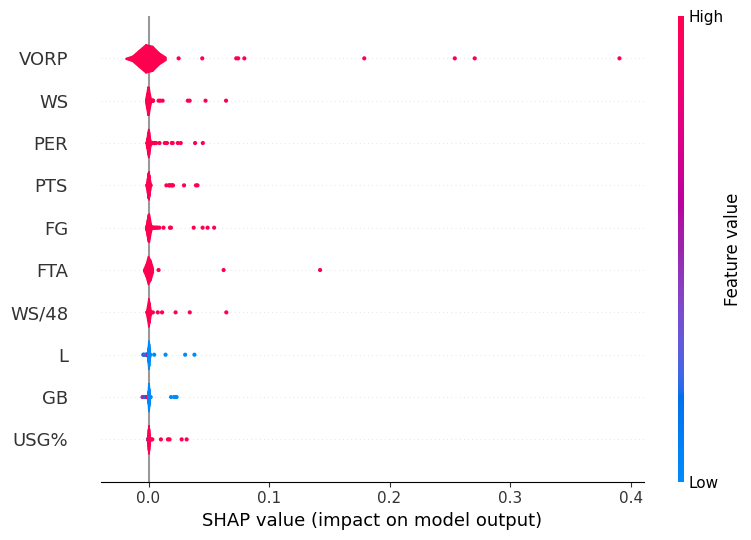

In [136]:
explainer = shap.Explainer(grid_rfg.predict, X_test_clean)

shap_values = explainer.shap_values(X_test_clean)

explainer = shap.Explainer(grid_rfg.predict, X_test_clean)

shap_values = explainer(X_test_clean)

shap.summary_plot(
    shap_values, 
    X_test_clean,
    plot_type="violin",
    color_bar=True,
    max_display=10, 
    show=False
)